In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

### Data Loading and Preparation

In [90]:
dvd_rental_info = pd.read_csv("rental_info.csv", parse_dates=['rental_date', 'return_date'])
dvd_rental_info.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [91]:
dvd_rental_info.info()
# no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   rental_date       15861 non-null  datetime64[ns, UTC]
 1   return_date       15861 non-null  datetime64[ns, UTC]
 2   amount            15861 non-null  float64            
 3   release_year      15861 non-null  float64            
 4   rental_rate       15861 non-null  float64            
 5   length            15861 non-null  float64            
 6   replacement_cost  15861 non-null  float64            
 7   special_features  15861 non-null  object             
 8   NC-17             15861 non-null  int64              
 9   PG                15861 non-null  int64              
 10  PG-13             15861 non-null  int64              
 11  R                 15861 non-null  int64              
 12  amount_2          15861 non-null  float64            
 13  l

### Feature Engineering

In [92]:
dvd_rental_info['rental_length_days'] = (dvd_rental_info['return_date'] - dvd_rental_info['rental_date']).dt.days
dvd_rental_info['rental_length_days'].head()

0    3
1    2
2    7
3    2
4    4
Name: rental_length_days, dtype: int64

In [93]:
# dvd_rental_info['deleted_scenes'] = dvd_rental_info['special_features'].apply(lambda x: 1 if 'Deleted Scenes' in x else 0)
dvd_rental_info['deleted_scenes'] = np.where(dvd_rental_info['special_features'].str.contains('Deleted Scenes'), 1, 0)
dvd_rental_info['behind_the_scenes'] = np.where(dvd_rental_info['special_features'].str.contains('Behind the Scenes'), 1, 0) 

In [94]:
dvd_rental_info.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4,0,1


### Train-Test Split

In [95]:
X = dvd_rental_info.drop(columns=['rental_date', 'return_date', 'special_features', 'rental_length_days'])
y = dvd_rental_info['rental_length_days']

In [96]:
SEED = 9
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [97]:
# generally, it's better to standardize your features before fitting ML models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

### Model Training and Evaluation

In [98]:
gbt = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=SEED)
gbt.fit(X_train_scaled, y_train)
y_pred = gbt.predict(X_test_scaled)
print(f"Test MSE: {mean_squared_error(y_test, y_pred)}")

Test MSE: 2.4253464800253557


In [99]:
# use training data instead of X, y in order to prevent data leakage
MSE_CV = -cross_val_score(gbt, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
y_pred_train = gbt.predict(X_train_scaled)

print(f'CV MSE: {MSE_CV.mean():.2f}')
print(f'Train MSE: {mean_squared_error(y_train, y_pred_train):.2f}')
# CV MSE is near to Train MSE, so there is no overfitting

CV MSE: 2.33
Train MSE: 2.28


### Feature importance

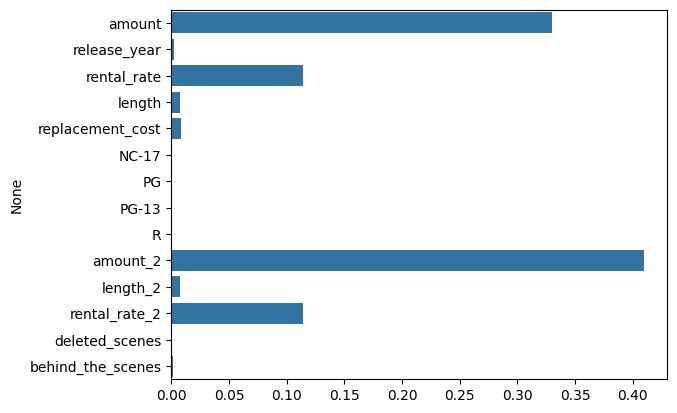

In [100]:
sns.barplot(x=gbt.feature_importances_, y=X.columns)
plt.show()

### Testing other models

In [101]:
# instantiate a GradientBoostingRegressor consisting of 300 decision-stumps
dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=0.1, random_state=SEED)
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)
print(f"Test MSE: {mean_squared_error(y_test, y_pred)}")

Test MSE: 3.274658361722676


In [102]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
print(f"Test MSE: {mean_squared_error(y_test, y_pred)}")

Test MSE: 2.9417238646975963


In [103]:
br = BaggingRegressor(estimator=dt, n_estimators=300, random_state=SEED)
br.fit(X_train_scaled, y_train)
y_pred = br.predict(X_test_scaled)
print(f"Test MSE: {mean_squared_error(y_test, y_pred)}")

Test MSE: 3.942648392178872


In [104]:
rf = RandomForestRegressor(n_estimators=300, min_samples_leaf=0.1, random_state=SEED)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
print(f"Test MSE: {mean_squared_error(y_test, y_pred)}")

Test MSE: 3.942648392178872


In [105]:
adb = AdaBoostRegressor(estimator=dt, n_estimators=300, random_state=SEED)
adb.fit(X_train_scaled, y_train)
y_pred = adb.predict(X_test_scaled)
best_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mean_squared_error(y_test, y_pred)}")

Test MSE: 2.9575993778789162


`GradientBoostingRegressor` results in the best **MSE**, so let's performed hyperparameter tuning for GBR using `RandomizedSearchCV` 

In [106]:
param_grid = {
    'n_estimators': np.arange(50, 101),
    'max_depth': np.arange(1, 11)
}
rand_search = RandomizedSearchCV(estimator=GradientBoostingRegressor(), param_distributions=param_grid, cv=5, random_state=SEED)
rand_search.fit(X_train, y_train)

hyper_params = rand_search.best_params_
print('best params:', hyper_params)

y_pred = rand_search.predict(X_test)
best_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {best_mse}")

best params: {'n_estimators': 94, 'max_depth': 8}
Test MSE: 1.9561438229415369


In [113]:
best_model = rand_search.best_estimator_
print(best_model)

GradientBoostingRegressor(max_depth=8, n_estimators=94)
